In [5]:
import os
import sys
import time
import datetime
import numpy as np
import os.path as osp
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torch.optim import lr_scheduler
import models
sys.path.append("./libs")  # Adds higher directory to python modules path.
from utils import accuracy, AverageMeter,ProgressMeter, Logger, save_checkpoint
from dataManager import AfosrDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib notebook
import torchvision.datasets as datasets
import wandb
wandb.login(timeout=30)

wandb: Currently logged in as: nhquanst. Use `wandb login --relogin` to force relogin


True

In [6]:
def train(model, criterion_xent, optimizer, trainloader, device):
    model.train()
    global print_freq
    losses = AverageMeter('training loss')
    for batch_idx,(imgs, targets) in enumerate(trainloader):
        imgs, targets = imgs.cuda(device), targets.cuda(device)        
        outputs, features = model(imgs)
        xent_loss = criterion_xent(outputs, targets) # cross entropy loss     
        loss= xent_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.update(loss.data, targets.size(0))   
        acc1, acc5,acc10 = accuracy(outputs, targets, topk=(1, 5,10))
        trainlog={
            "train_acc_top1":acc1,
            "train_acc_top5":acc5,
            "train_acc_top10":acc10,
        }
#         wandb.log(trainlog)        
        if (batch_idx+1) % config.print_freq == 0:
            print("Train batch {}/{}\t Loss {:.6f} ({:.6f})"
                  .format(batch_idx+1, len(trainloader), losses.val, losses.avg))
    return losses.avg

In [7]:
def validate(model, criterion_xent, val_loader, device):
    model.eval()
    
    global print_freq
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.3f')
    top5 = AverageMeter('Acc@5', ':6.3f')
    top10 = AverageMeter('Acc@10', ':6.3f')

    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1, top5, top10],
        prefix='Test:')    
    with torch.no_grad():
        end = time.time()
        for batch_idx,(imgs, targets) in enumerate(val_loader):
            imgs, targets = imgs.cuda(device), targets.cuda(device)            
            outputs, features = model(imgs)
            xent_loss = criterion_xent(outputs, targets) # cross entropy loss           
            loss= xent_loss
            losses.update(loss.data, imgs.size(0))
            
            acc1, acc5,acc10 = accuracy(outputs, targets, topk=(1, 5,10))            
            top1.update(acc1[0], imgs.size(0))
            top5.update(acc5[0], imgs.size(0))
            top10.update(acc10[0], imgs.size(0))
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
            if batch_idx % config.print_freq == 0:
                progress.display(batch_idx)
            
            vallog={
                "val_acc_top1":acc1,
                "val_acc_top5":acc5,
                "val_acc_top10":acc10,
            }
#             wandb.log(vallog)

        # TODO: this should also be done with the ProgressMeter
        print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f} Acc@10 {top10.avg:.3f}'
              .format(top1=top1, top5=top5, top10=top10))
    return losses.avg,top1.avg, top5.avg, top10.avg

train item: 3633
Test item: 1775
Initializing model: resnet18
Model size: 11.18267M


<IPython.core.display.Javascript object>


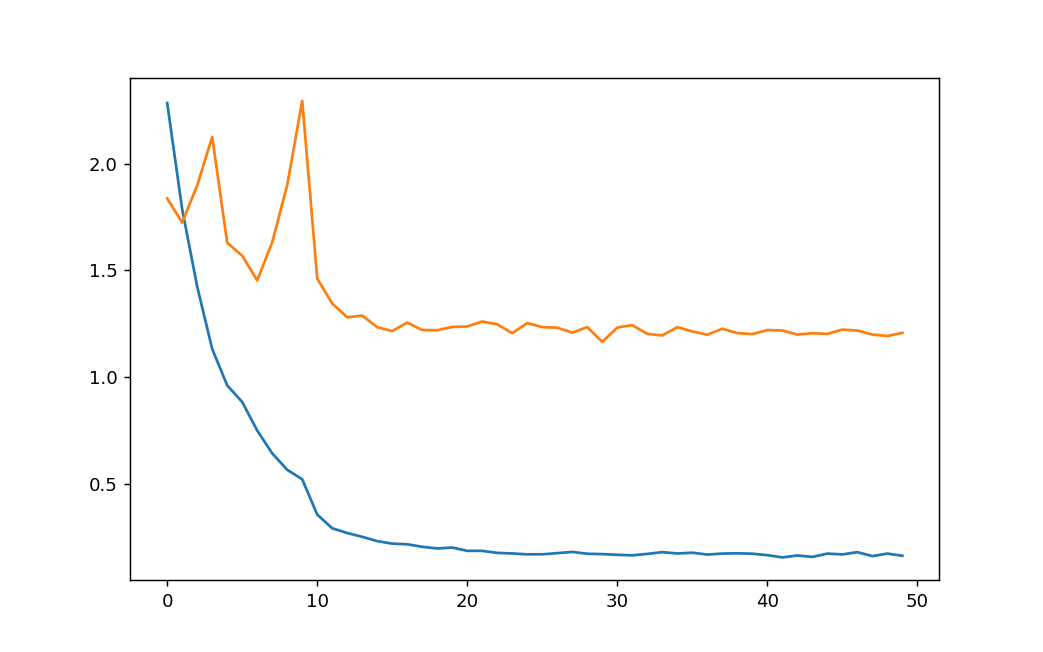

==> Epoch 1/50
Train batch 10/114	 Loss 2.518686 (2.525502)
Train batch 20/114	 Loss 2.568882 (2.542756)
Train batch 30/114	 Loss 2.503638 (2.535503)
Train batch 40/114	 Loss 2.354614 (2.514444)
Train batch 50/114	 Loss 2.216760 (2.483389)
Train batch 60/114	 Loss 2.558715 (2.463767)
Train batch 70/114	 Loss 2.336121 (2.425977)
Train batch 80/114	 Loss 2.140638 (2.399054)
Train batch 90/114	 Loss 1.951316 (2.364647)
Train batch 100/114	 Loss 1.930096 (2.327608)
Train batch 110/114	 Loss 1.859921 (2.298130)
Test:[  0/111]	Time  0.682( 0.682)	Loss 1.6956e+00(1.6956e+00)	Acc@1 37.500(37.500)	Acc@5 81.250(81.250)	Acc@10 100.000(100.000)
Test:[ 10/111]	Time  0.090( 0.156)	Loss 1.9287e+00(1.9151e+00)	Acc@1 31.250(32.386)	Acc@5 81.250(80.682)	Acc@10 100.000(99.432)
Test:[ 20/111]	Time  0.420( 0.149)	Loss 1.5360e+00(1.7898e+00)	Acc@1 37.500(35.119)	Acc@5 100.000(85.119)	Acc@10 100.000(99.702)
Test:[ 30/111]	Time  0.026( 0.132)	Loss 1.8070e+00(1.8896e+00)	Acc@1 31.250(31.250)	Acc@5 100.000(83.6

==> Epoch 5/50
Train batch 10/114	 Loss 1.021543 (1.016007)
Train batch 20/114	 Loss 1.214015 (1.020689)
Train batch 30/114	 Loss 1.236711 (1.010882)
Train batch 40/114	 Loss 1.158862 (1.003623)
Train batch 50/114	 Loss 0.984486 (1.015005)
Train batch 60/114	 Loss 0.932178 (0.991788)
Train batch 70/114	 Loss 1.222865 (0.974805)
Train batch 80/114	 Loss 1.054845 (0.962234)
Train batch 90/114	 Loss 1.237264 (0.964119)
Train batch 100/114	 Loss 0.729418 (0.966268)
Train batch 110/114	 Loss 0.886488 (0.965537)
Test:[  0/111]	Time  0.651( 0.651)	Loss 1.2024e+00(1.2024e+00)	Acc@1 81.250(81.250)	Acc@5 87.500(87.500)	Acc@10 100.000(100.000)
Test:[ 10/111]	Time  0.016( 0.147)	Loss 1.3356e+00(1.3314e+00)	Acc@1 62.500(61.932)	Acc@5 93.750(88.636)	Acc@10 100.000(99.432)
Test:[ 20/111]	Time  0.413( 0.141)	Loss 1.2257e+00(1.3155e+00)	Acc@1 56.250(60.417)	Acc@5 93.750(91.667)	Acc@10 100.000(99.405)
Test:[ 30/111]	Time  0.015( 0.128)	Loss 9.3849e-01(1.7225e+00)	Acc@1 68.750(53.831)	Acc@5 93.750(87.097

Test:[110/111]	Time  0.012( 0.117)	Loss 1.9514e+00(1.6318e+00)	Acc@1 60.000(51.268)	Acc@5 73.333(88.620)	Acc@10 100.000(99.042)
 * Acc@1 51.268 Acc@5 88.620 Acc@10 99.042
==> Epoch 9/50
Train batch 10/114	 Loss 0.369685 (0.508972)
Train batch 20/114	 Loss 0.761676 (0.572442)
Train batch 30/114	 Loss 0.699263 (0.554892)
Train batch 40/114	 Loss 0.489578 (0.544471)
Train batch 50/114	 Loss 0.579804 (0.556225)
Train batch 60/114	 Loss 0.759496 (0.547339)
Train batch 70/114	 Loss 0.445255 (0.549881)
Train batch 80/114	 Loss 0.535918 (0.547144)
Train batch 90/114	 Loss 0.570789 (0.554692)
Train batch 100/114	 Loss 0.566791 (0.558724)
Train batch 110/114	 Loss 0.322060 (0.562596)
Test:[  0/111]	Time  0.653( 0.653)	Loss 1.8246e+00(1.8246e+00)	Acc@1 75.000(75.000)	Acc@5 87.500(87.500)	Acc@10 93.750(93.750)
Test:[ 10/111]	Time  0.030( 0.147)	Loss 1.4399e+00(1.7503e+00)	Acc@1 68.750(55.682)	Acc@5 87.500(85.795)	Acc@10 100.000(97.727)
Test:[ 20/111]	Time  0.405( 0.141)	Loss 1.4830e+00(1.6309e+00)

Test:[100/111]	Time  0.399( 0.119)	Loss 5.6941e-01(1.3198e+00)	Acc@1 81.250(60.891)	Acc@5 100.000(93.069)	Acc@10 100.000(98.948)
Test:[110/111]	Time  0.017( 0.117)	Loss 1.6900e+00(1.3452e+00)	Acc@1 60.000(60.451)	Acc@5 80.000(92.845)	Acc@10 100.000(99.042)
 * Acc@1 60.451 Acc@5 92.845 Acc@10 99.042
==> Epoch 13/50
Train batch 10/114	 Loss 0.365486 (0.275286)
Train batch 20/114	 Loss 0.199112 (0.262142)
Train batch 30/114	 Loss 0.223728 (0.267312)
Train batch 40/114	 Loss 0.111482 (0.263490)
Train batch 50/114	 Loss 0.270166 (0.263332)
Train batch 60/114	 Loss 0.304950 (0.266498)
Train batch 70/114	 Loss 0.308431 (0.263397)
Train batch 80/114	 Loss 0.119624 (0.265712)
Train batch 90/114	 Loss 0.185072 (0.262510)
Train batch 100/114	 Loss 0.205226 (0.269089)
Train batch 110/114	 Loss 0.254543 (0.271872)
Test:[  0/111]	Time  0.651( 0.651)	Loss 1.2135e+00(1.2135e+00)	Acc@1 75.000(75.000)	Acc@5 93.750(93.750)	Acc@10 93.750(93.750)
Test:[ 10/111]	Time  0.025( 0.146)	Loss 5.8530e-01(1.0414e+0

Test:[ 90/111]	Time  0.014( 0.118)	Loss 4.1313e-01(1.2493e+00)	Acc@1 75.000(61.470)	Acc@5 100.000(94.643)	Acc@10 100.000(99.451)
Test:[100/111]	Time  0.407( 0.119)	Loss 6.7335e-01(1.1845e+00)	Acc@1 68.750(62.933)	Acc@5 100.000(95.173)	Acc@10 100.000(99.505)
Test:[110/111]	Time  0.012( 0.117)	Loss 1.5683e+00(1.2159e+00)	Acc@1 60.000(62.310)	Acc@5 86.667(94.930)	Acc@10 100.000(99.549)
 * Acc@1 62.310 Acc@5 94.930 Acc@10 99.549
==> Epoch 17/50
Train batch 10/114	 Loss 0.511290 (0.247283)
Train batch 20/114	 Loss 0.172905 (0.242682)
Train batch 30/114	 Loss 0.240740 (0.234645)
Train batch 40/114	 Loss 0.151011 (0.224773)
Train batch 50/114	 Loss 0.126888 (0.220133)
Train batch 60/114	 Loss 0.296062 (0.219597)
Train batch 70/114	 Loss 0.143399 (0.220803)
Train batch 80/114	 Loss 0.222983 (0.222201)
Train batch 90/114	 Loss 0.098082 (0.216586)
Train batch 100/114	 Loss 0.396034 (0.216468)
Train batch 110/114	 Loss 0.119931 (0.213889)
Test:[  0/111]	Time  0.674( 0.674)	Loss 1.3353e+00(1.3353e

Test:[ 80/111]	Time  0.384( 0.121)	Loss 2.5004e+00(1.3097e+00)	Acc@1 43.750(63.040)	Acc@5 81.250(93.827)	Acc@10 93.750(98.997)
Test:[ 90/111]	Time  0.019( 0.118)	Loss 4.9411e-01(1.2741e+00)	Acc@1 81.250(62.843)	Acc@5 100.000(94.162)	Acc@10 100.000(99.107)
Test:[100/111]	Time  0.371( 0.119)	Loss 6.2209e-01(1.2087e+00)	Acc@1 75.000(64.295)	Acc@5 100.000(94.740)	Acc@10 100.000(99.196)
Test:[110/111]	Time  0.013( 0.117)	Loss 1.5072e+00(1.2352e+00)	Acc@1 66.667(63.662)	Acc@5 86.667(94.535)	Acc@10 100.000(99.211)
 * Acc@1 63.662 Acc@5 94.535 Acc@10 99.211
==> Epoch 21/50
Train batch 10/114	 Loss 0.211986 (0.185086)
Train batch 20/114	 Loss 0.115414 (0.177062)
Train batch 30/114	 Loss 0.217329 (0.189812)
Train batch 40/114	 Loss 0.270748 (0.182105)
Train batch 50/114	 Loss 0.183357 (0.184594)
Train batch 60/114	 Loss 0.241258 (0.185727)
Train batch 70/114	 Loss 0.189326 (0.186376)
Train batch 80/114	 Loss 0.247384 (0.189675)
Train batch 90/114	 Loss 0.180496 (0.193279)
Train batch 100/114	 Lo

Test:[ 70/111]	Time  0.017( 0.127)	Loss 8.9900e-01(1.2737e+00)	Acc@1 68.750(62.500)	Acc@5 100.000(94.718)	Acc@10 100.000(98.944)
Test:[ 80/111]	Time  0.394( 0.128)	Loss 2.5302e+00(1.2795e+00)	Acc@1 37.500(63.040)	Acc@5 81.250(93.904)	Acc@10 93.750(98.997)
Test:[ 90/111]	Time  0.014( 0.124)	Loss 4.5611e-01(1.2466e+00)	Acc@1 81.250(62.843)	Acc@5 100.000(94.231)	Acc@10 100.000(99.107)
Test:[100/111]	Time  0.399( 0.125)	Loss 6.4530e-01(1.1805e+00)	Acc@1 68.750(64.171)	Acc@5 100.000(94.802)	Acc@10 100.000(99.196)
Test:[110/111]	Time  0.013( 0.122)	Loss 1.4775e+00(1.2061e+00)	Acc@1 60.000(63.380)	Acc@5 86.667(94.479)	Acc@10 100.000(99.211)
 * Acc@1 63.380 Acc@5 94.479 Acc@10 99.211
==> Epoch 25/50
Train batch 10/114	 Loss 0.105745 (0.121474)
Train batch 20/114	 Loss 0.250109 (0.150112)
Train batch 30/114	 Loss 0.080771 (0.145918)
Train batch 40/114	 Loss 0.166319 (0.157064)
Train batch 50/114	 Loss 0.332277 (0.169209)
Train batch 60/114	 Loss 0.128932 (0.168506)
Train batch 70/114	 Loss 0.22

Test:[ 60/111]	Time  0.422( 0.128)	Loss 7.3339e-01(1.3768e+00)	Acc@1 68.750(60.553)	Acc@5 93.750(93.852)	Acc@10 100.000(98.770)
Test:[ 70/111]	Time  0.014( 0.123)	Loss 7.6847e-01(1.2788e+00)	Acc@1 75.000(62.588)	Acc@5 100.000(94.630)	Acc@10 100.000(98.944)
Test:[ 80/111]	Time  0.395( 0.123)	Loss 2.4837e+00(1.2852e+00)	Acc@1 37.500(63.194)	Acc@5 68.750(93.750)	Acc@10 93.750(98.997)
Test:[ 90/111]	Time  0.018( 0.121)	Loss 4.5636e-01(1.2558e+00)	Acc@1 81.250(62.706)	Acc@5 100.000(94.093)	Acc@10 100.000(99.107)
Test:[100/111]	Time  0.402( 0.123)	Loss 6.0364e-01(1.1893e+00)	Acc@1 68.750(64.047)	Acc@5 100.000(94.678)	Acc@10 100.000(99.196)
Test:[110/111]	Time  0.018( 0.120)	Loss 1.4708e+00(1.2086e+00)	Acc@1 66.667(63.493)	Acc@5 86.667(94.366)	Acc@10 100.000(99.211)
 * Acc@1 63.493 Acc@5 94.366 Acc@10 99.211
==> Epoch 29/50
Train batch 10/114	 Loss 0.067865 (0.186762)
Train batch 20/114	 Loss 0.304568 (0.181164)
Train batch 30/114	 Loss 0.233529 (0.190080)
Train batch 40/114	 Loss 0.152253 (0

Test:[ 50/111]	Time  0.017( 0.122)	Loss 1.5155e+00(1.4417e+00)	Acc@1 62.500(61.397)	Acc@5 87.500(91.912)	Acc@10 100.000(98.407)
Test:[ 60/111]	Time  0.419( 0.124)	Loss 7.3141e-01(1.3993e+00)	Acc@1 81.250(61.885)	Acc@5 100.000(93.033)	Acc@10 100.000(98.668)
Test:[ 70/111]	Time  0.014( 0.120)	Loss 9.5455e-01(1.3039e+00)	Acc@1 62.500(63.468)	Acc@5 100.000(93.926)	Acc@10 100.000(98.856)
Test:[ 80/111]	Time  0.398( 0.121)	Loss 2.6337e+00(1.3187e+00)	Acc@1 43.750(63.503)	Acc@5 75.000(93.210)	Acc@10 93.750(98.920)
Test:[ 90/111]	Time  0.015( 0.119)	Loss 4.0993e-01(1.2927e+00)	Acc@1 81.250(63.049)	Acc@5 100.000(93.544)	Acc@10 100.000(99.038)
Test:[100/111]	Time  0.412( 0.120)	Loss 6.4623e-01(1.2208e+00)	Acc@1 68.750(64.666)	Acc@5 100.000(94.183)	Acc@10 100.000(99.134)
Test:[110/111]	Time  0.014( 0.119)	Loss 1.6303e+00(1.2437e+00)	Acc@1 46.667(63.944)	Acc@5 86.667(93.915)	Acc@10 100.000(99.211)
 * Acc@1 63.944 Acc@5 93.915 Acc@10 99.211
==> Epoch 33/50
Train batch 10/114	 Loss 0.143452 (0.17231

Test:[ 40/111]	Time  0.372( 0.128)	Loss 2.6110e+00(1.3923e+00)	Acc@1 43.750(60.518)	Acc@5 81.250(92.988)	Acc@10 93.750(98.171)
Test:[ 50/111]	Time  0.033( 0.121)	Loss 1.4733e+00(1.4340e+00)	Acc@1 62.500(61.029)	Acc@5 87.500(92.525)	Acc@10 100.000(98.529)
Test:[ 60/111]	Time  0.378( 0.123)	Loss 7.1680e-01(1.3846e+00)	Acc@1 75.000(61.578)	Acc@5 100.000(93.545)	Acc@10 100.000(98.770)
Test:[ 70/111]	Time  0.023( 0.118)	Loss 8.0093e-01(1.2853e+00)	Acc@1 75.000(63.468)	Acc@5 100.000(94.366)	Acc@10 100.000(98.944)
Test:[ 80/111]	Time  0.351( 0.119)	Loss 2.5139e+00(1.2933e+00)	Acc@1 37.500(63.812)	Acc@5 68.750(93.519)	Acc@10 93.750(98.997)
Test:[ 90/111]	Time  0.017( 0.117)	Loss 4.6249e-01(1.2603e+00)	Acc@1 81.250(63.324)	Acc@5 100.000(93.887)	Acc@10 100.000(99.107)
Test:[100/111]	Time  0.354( 0.119)	Loss 6.2383e-01(1.1930e+00)	Acc@1 62.500(64.728)	Acc@5 100.000(94.431)	Acc@10 100.000(99.196)
Test:[110/111]	Time  0.013( 0.116)	Loss 1.4479e+00(1.2144e+00)	Acc@1 66.667(64.169)	Acc@5 86.667(94.14

Test:[ 30/111]	Time  0.016( 0.126)	Loss 6.5891e-01(1.2500e+00)	Acc@1 68.750(63.710)	Acc@5 100.000(94.960)	Acc@10 100.000(98.992)
Test:[ 40/111]	Time  0.415( 0.129)	Loss 2.6015e+00(1.3744e+00)	Acc@1 37.500(61.128)	Acc@5 75.000(92.683)	Acc@10 93.750(98.323)
Test:[ 50/111]	Time  0.057( 0.122)	Loss 1.4109e+00(1.4132e+00)	Acc@1 68.750(61.152)	Acc@5 93.750(92.525)	Acc@10 100.000(98.652)
Test:[ 60/111]	Time  0.357( 0.123)	Loss 7.1232e-01(1.3629e+00)	Acc@1 81.250(61.783)	Acc@5 93.750(93.443)	Acc@10 100.000(98.873)
Test:[ 70/111]	Time  0.045( 0.119)	Loss 8.4667e-01(1.2662e+00)	Acc@1 68.750(63.732)	Acc@5 100.000(94.366)	Acc@10 100.000(99.032)
Test:[ 80/111]	Time  0.329( 0.120)	Loss 2.4620e+00(1.2773e+00)	Acc@1 43.750(64.043)	Acc@5 68.750(93.519)	Acc@10 93.750(99.074)
Test:[ 90/111]	Time  0.032( 0.118)	Loss 4.6407e-01(1.2457e+00)	Acc@1 81.250(63.805)	Acc@5 100.000(93.887)	Acc@10 100.000(99.176)
Test:[100/111]	Time  0.315( 0.118)	Loss 5.6658e-01(1.1785e+00)	Acc@1 75.000(65.161)	Acc@5 100.000(94.49

Test:[ 20/111]	Time  0.410( 0.140)	Loss 7.2721e-01(9.2450e-01)	Acc@1 75.000(70.238)	Acc@5 100.000(97.619)	Acc@10 100.000(99.702)
Test:[ 30/111]	Time  0.017( 0.125)	Loss 6.3070e-01(1.2562e+00)	Acc@1 75.000(64.718)	Acc@5 100.000(95.565)	Acc@10 100.000(98.992)
Test:[ 40/111]	Time  0.404( 0.127)	Loss 2.5890e+00(1.3762e+00)	Acc@1 37.500(61.738)	Acc@5 81.250(93.598)	Acc@10 93.750(98.323)
Test:[ 50/111]	Time  0.025( 0.120)	Loss 1.4298e+00(1.4123e+00)	Acc@1 62.500(61.887)	Acc@5 93.750(93.382)	Acc@10 100.000(98.652)
Test:[ 60/111]	Time  0.394( 0.122)	Loss 7.0387e-01(1.3684e+00)	Acc@1 75.000(62.295)	Acc@5 93.750(94.160)	Acc@10 100.000(98.873)
Test:[ 70/111]	Time  0.016( 0.118)	Loss 9.1547e-01(1.2735e+00)	Acc@1 62.500(63.820)	Acc@5 100.000(94.982)	Acc@10 100.000(99.032)
Test:[ 80/111]	Time  0.367( 0.119)	Loss 2.4996e+00(1.2836e+00)	Acc@1 50.000(63.966)	Acc@5 75.000(93.981)	Acc@10 93.750(99.074)
Test:[ 90/111]	Time  0.020( 0.116)	Loss 4.0484e-01(1.2501e+00)	Acc@1 81.250(63.668)	Acc@5 100.000(94.36

Test:[ 10/111]	Time  0.016( 0.149)	Loss 5.0525e-01(9.2437e-01)	Acc@1 81.250(73.295)	Acc@5 100.000(94.886)	Acc@10 100.000(99.432)
Test:[ 20/111]	Time  0.415( 0.144)	Loss 7.6731e-01(9.2567e-01)	Acc@1 75.000(69.940)	Acc@5 100.000(97.024)	Acc@10 100.000(99.702)
Test:[ 30/111]	Time  0.017( 0.127)	Loss 6.5614e-01(1.2449e+00)	Acc@1 75.000(63.911)	Acc@5 100.000(95.363)	Acc@10 100.000(98.992)
Test:[ 40/111]	Time  0.396( 0.129)	Loss 2.4944e+00(1.3681e+00)	Acc@1 37.500(61.280)	Acc@5 81.250(92.835)	Acc@10 93.750(98.476)
Test:[ 50/111]	Time  0.014( 0.122)	Loss 1.3808e+00(1.4078e+00)	Acc@1 62.500(61.152)	Acc@5 93.750(92.647)	Acc@10 100.000(98.652)
Test:[ 60/111]	Time  0.416( 0.123)	Loss 7.2026e-01(1.3574e+00)	Acc@1 75.000(61.783)	Acc@5 100.000(93.750)	Acc@10 100.000(98.873)
Test:[ 70/111]	Time  0.014( 0.119)	Loss 8.4064e-01(1.2611e+00)	Acc@1 62.500(63.468)	Acc@5 100.000(94.630)	Acc@10 100.000(99.032)
Test:[ 80/111]	Time  0.389( 0.120)	Loss 2.3747e+00(1.2715e+00)	Acc@1 43.750(63.966)	Acc@5 81.250(93.

train_loss,█▆▅▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▅▆█▄▃▄▆▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_top1,▁▃▃▄▅▆▅▅▇▇▇▇▇▇██████████████████████████
val_top10,▇▆▁▇██▇▇▇▇██████████████████████████████
val_top5,▄▃▁▃▅▆▅▅▆▇█▇█▇██████████████████████████
The best acc:,65.35212
train_loss,0.16385
val_loss,1.20756
val_top1,64.33803
val_top10,99.26761
val_top5,94.19719


In [10]:
# 🐝 initialise a wandb run
wandb.init(
    project="Afosr_2022_MHI",
    config={
        "project":"Afosr_2022_MHI",
        "data_path":"/mnt/works/projectComvis/AFOSR-2020/MotionHistoryImage/MHI_images",
        "arch":"resnet18",
        "split":"split_by_env",     # split_by_env , split_by_sub  
        "train_batch":32,
        "test_batch":16,
        "num_classes":12,
        "workers":4,
        "weight_decay":5e-04,
        "momentum":0.9,
        "lr":0.003,
        "gamma":0.1,
        "max_epoch":50,
        "stepsize":10, # to modify lr
        "eval_step":1, #         
        "print_freq":10,
        })

# Copy your config 
config = wandb.config
save_dir = os.path.join("./log", config.project,"%s_%s" % (config.arch,config.split))
train_list=os.path.join("/home/nhquan/datasets/afosr2022",config.split, "train.txt")
test_list=os.path.join("/home/nhquan/datasets/afosr2022", config.split,"val.txt")


# torch.manual_seed(100)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

scaler = transforms.Resize((224,224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])    


transform4train= transforms.Compose([
    transforms.RandomRotation(degrees=(-90, 90)),
    scaler,
    transforms.ToTensor(),
    normalize       
    ])   

transform4test= transforms.Compose([
    scaler,
    transforms.ToTensor(),
    normalize       
    ])     


# trainDataset = datasets.ImageFolder("./data/data_huy/train/",transform)
# testDataset=datasets.ImageFolder("./data/data_huy/test/", transform)

trainDataset = AfosrDataset(config.data_path,train_list,transform=transform4train) 
print("train item:",trainDataset.__len__())
testDataset = AfosrDataset(config.data_path,test_list,transform=transform4test) 
print("Test item:",testDataset.__len__())

trainLoader = DataLoader(trainDataset, batch_size=config.train_batch, 
                         shuffle=True, num_workers=config.workers)
testLoader = DataLoader(testDataset, batch_size=config.test_batch, 
                        shuffle=False, num_workers=config.workers)


print("Initializing model: {}".format(config.arch))
model = models.init_model(name=config.arch, num_classes=config.num_classes)
print("Model size: {:.5f}M".format(sum(p.numel() for p in model.parameters())/1000000.0))
model.cuda(device)

# criterion = nn.CrossEntropyLoss().cuda()
criterion_xent = criterion = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
optimizer = torch.optim.SGD(model.parameters(), lr=config.lr, 
                            momentum=config.momentum, weight_decay=config.weight_decay)

if config.stepsize > 0:
    scheduler = lr_scheduler.StepLR(optimizer, step_size=config.stepsize, gamma=config.gamma)

## Train model
train_loss_values=[]
test_loss_values=[]
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111) # for acce
fig.show()    
# ax.set_xlim(left=0, right=len(lines)+10)
        
start_time = time.time()
best_rank1 = -np.inf
for epoch in range(0, config.max_epoch):
    print("==> Epoch {}/{}".format(epoch+1, config.max_epoch))        
    train_loss=train(model, criterion_xent, optimizer, trainLoader, device).cpu()  
    train_loss_values.append(train_loss)
    if config.stepsize > 0: scheduler.step()
    if (epoch+1)%config.eval_step==0:
        val_loss,acc1,acc5,acc10= validate(model, criterion_xent,testLoader,device)
        val_loss=val_loss.cpu()
        test_loss_values.append(val_loss)
        if best_rank1<acc1:
            best_rank1=acc1
            save_checkpoint({
                'state_dict': model.state_dict(),
                'epoch': epoch,
                }, False, osp.join(save_dir, 'best_checkpoint'  + '.pth.tar'))
        ax.clear()
        ax.plot(train_loss_values)
        ax.plot(test_loss_values)    
        fig.canvas.draw()  
        val_log={"train_loss": train_loss, 
                "val_loss": val_loss,
                "val_top1":acc1,
               "val_top5":acc5,
               "val_top10":acc10}
    wandb.log(val_log)
print('The best acc: ',best_rank1)
elapsed = round(time.time() - start_time)
elapsed = str(datetime.timedelta(seconds=elapsed))
print("Finished. Total elapsed time (h:m:s): {}".format(elapsed))
# plt.plot(train_loss_values)
# plt.plot(test_loss_values)

wandb.summary['The best acc: '] = best_rank1
wandb.finish()

# Test model

In [6]:
import os
import sys
import time
import datetime
import os.path as osp
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import models
sys.path.append("libs")  # Adds higher directory to python modules path.
from utils import accuracy, AverageMeter,ProgressMeter, Logger, FusionMatrix 
from dataManager import AfosrDataset
# from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib notebook

for arch in ['resnet18', 'resnet50']:  
    for split  in ['split_by_sub', 'split_by_env']: 
        data_path='/mnt/works/projectComvis/AFOSR-2020/MotionHistoryImage/MHI_images'
        test_list = '/home/nhquan/datasets/afosr2022/%s/val.txt' % (split)
        save_dir='./log/Afosr_2022_MHI/%s_%s' % (arch,split)
        weightFile='./log/Afosr_2022_MHI/%s_%s/best_checkpoint.pth.tar' % (arch,split)
        test_batch=32
        num_classes=12
        workers=4
        print_freq=20

        # torch.manual_seed(100)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        scaler = transforms.Resize((224,224))
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])    
        transform= transforms.Compose([
            scaler,
            transforms.ToTensor(),
            normalize       
            ])     

        testDataset = AfosrDataset(data_path,test_list,transform=transform) 
        testLoader = DataLoader(testDataset, batch_size=test_batch, shuffle=False, num_workers=workers)
        print("Initializing model: {}".format(arch))
        model = models.init_model(name=arch, num_classes=num_classes)
        print("Model size: {:.5f}M".format(sum(p.numel() for p in model.parameters())/1000000.0))
        checkpoint = torch.load(weightFile)
        model.load_state_dict(checkpoint['state_dict'], strict=False)
        # model.module.load_state_dict(checkpoint['state_dict'])
        model.eval()
        model.to(device)


        # from ptflops import get_model_complexity_info
        # with torch.cuda.device(0):
        #     flops, params = get_model_complexity_info(model, (3,224,224), as_strings=True, print_per_layer_stat=True, verbose=True)
        #     print('{:<30}  {:<8}'.format('Computational complexity: ', flops))
        #     print('{:<30}  {:<8}'.format('Number of parameters: ', params))


        fusion_matrix = FusionMatrix(num_classes)
        func = torch.nn.Softmax(dim=1)
        top1 = AverageMeter('Acc@1', ':6.3f')
        top5 = AverageMeter('Acc@5', ':6.3f')
        top10 = AverageMeter('Acc@10', ':6.3f')

        with torch.no_grad():
            end = time.time()
            for batch_idx,(imgs, targets) in enumerate(testLoader):
                imgs, targets = imgs.cuda(device), targets.cuda(device)            
                outputs, features = model(imgs)
                result = func(outputs)
        #         _, top_k = result.topk(10, 1, True, True)
                score_result = result.cpu().numpy()
                fusion_matrix.update(score_result.argmax(axis=1), targets.cpu().numpy())

                acc1, acc5,acc10 = accuracy(outputs, targets, topk=(1, 5,10))            
                top1.update(acc1[0], imgs.size(0))
                top5.update(acc5[0], imgs.size(0))
                top10.update(acc10[0], imgs.size(0))
        #         topk_result = top_k.cpu().tolist()                
        #     fig=fusion_matrix.plot_confusion_matrix(normalize = True) 
            info='%s_%s' % (arch,split)
            print('{info}: Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f} Acc@10 {top10.avg:.3f}'
                  .format(info=info,top1=top1, top5=top5, top10=top10))

Initializing model: resnet18
Model size: 11.18267M
resnet18_split_by_sub: Acc@1 66.253 Acc@5 94.526 Acc@10 99.549
Initializing model: resnet18
Model size: 11.18267M
resnet18_split_by_env: Acc@1 65.352 Acc@5 94.423 Acc@10 99.324
Initializing model: resnet50
Model size: 23.53262M
resnet50_split_by_sub: Acc@1 65.463 Acc@5 94.413 Acc@10 99.436
Initializing model: resnet50
Model size: 23.53262M
resnet50_split_by_env: Acc@1 68.563 Acc@5 97.239 Acc@10 99.887


In [ ]:
import numpy as np
cm=fusion_matrix.matrix.T
cm=cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
np.savetxt("confusion_splitby_env.csv", cm, delimiter=",") 

In [ ]:
f=fusion_matrix.plot_confusion_matrix(normalize = False) 
f.savefig("confusion_splitby_env.pdf", bbox_inches='tight')